In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import joblib
import re 

In [32]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
from notebook_helpers import get_db_connection
conn = get_db_connection()
query = """
    select 
        c.* 
    from 
        lb_users u
        join lb_posts p on p.user_id = u.id 
        join lb_comments c on c.post_id = p.id 
    where
        u.is_training 
        and c.classification in ('BOM','RUIM')
 """
df = pd.read_sql(query,conn)
conn.close()

C:\Users\marci\AppData\Local\Temp\ipykernel_20676\1284418873.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,conn)


In [34]:
df['label'] = df['classification'].map({'BOM' : 1, 'RUIM' : 0})

In [35]:
from notebook_helpers import clean_comment_text
df['comment_text'] = df['comment_text'].apply(clean_comment_text)

In [36]:
df = df[['comment_text', 'label']]

In [37]:
df.drop_duplicates(inplace=True)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'], df['label'], test_size=0.2, random_state=42)

In [39]:
models = {
    'LogisticRegression': (LogisticRegression(), {
        'logisticregression__C': [0.01, 0.1, 1, 10],
        'logisticregression__solver': ['liblinear'],
        'logisticregression__dual' : [False, True],
        'logisticregression__random_state' : [42],
    }),
    'RandomForestClassifier': (RandomForestClassifier(), {
        'randomforestclassifier__n_estimators': [25, 50, 100, 200, 225, 230, 300],
        'randomforestclassifier__max_depth': [None,5 , 10, 20],
        'randomforestclassifier__min_samples_split' : [2, 10, 20],
        'randomforestclassifier__min_samples_leaf' : [2, 10, 20],
        'randomforestclassifier__random_state' : [42],
    }),
    'SVC': (SVC(), {
        'svc__C': [0.1, 1, 10, 15, 20, 25],
        'svc__kernel': ['linear'],
        'svc__probability' : [True, False],
        'svc__gamma' : ['scale'],
        'svc__random_state' : [42] , 
    }),
    'NaiveBayes': (MultinomialNB(), {
        'naivebayes__alpha': [0.1, 0.5, 1.0]
        })
}
results = {}

In [40]:
best_estimator = {'f1-score' : 0, 'model' : None}

c:\Users\marci\OneDrive\Desktop\FIAP\POS\3 FASE\TC\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


---- LogisticRegression ----
              precision    recall  f1-score   support

         BOM       0.92      0.92      0.92        51
        RUIM       0.93      0.93      0.93        54

    accuracy                           0.92       105
   macro avg       0.92      0.92      0.92       105
weighted avg       0.92      0.92      0.92       105

Melhores parametros: {'logisticregression__C': 10, 'logisticregression__dual': False, 'logisticregression__random_state': 42, 'logisticregression__solver': 'liblinear'}
Melhor F1 ponderado (cross-validation): 0.9301



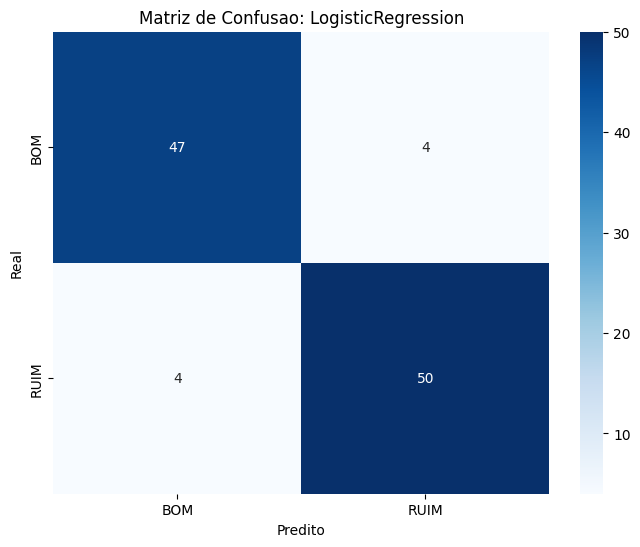

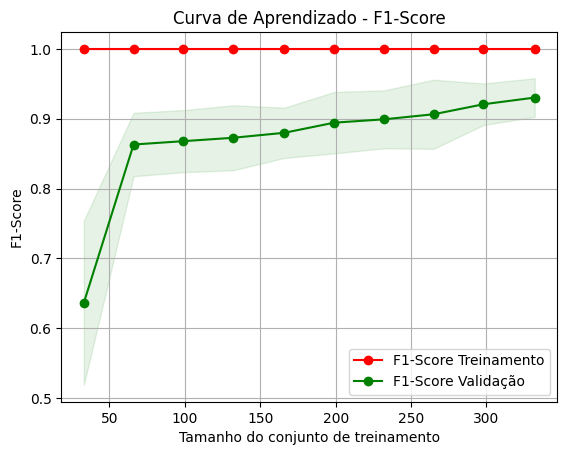

---- RandomForestClassifier ----
              precision    recall  f1-score   support

         BOM       0.92      0.67      0.77        51
        RUIM       0.75      0.94      0.84        54

    accuracy                           0.81       105
   macro avg       0.83      0.81      0.80       105
weighted avg       0.83      0.81      0.81       105

Melhores parametros: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 230, 'randomforestclassifier__random_state': 42}
Melhor F1 ponderado (cross-validation): 0.8599



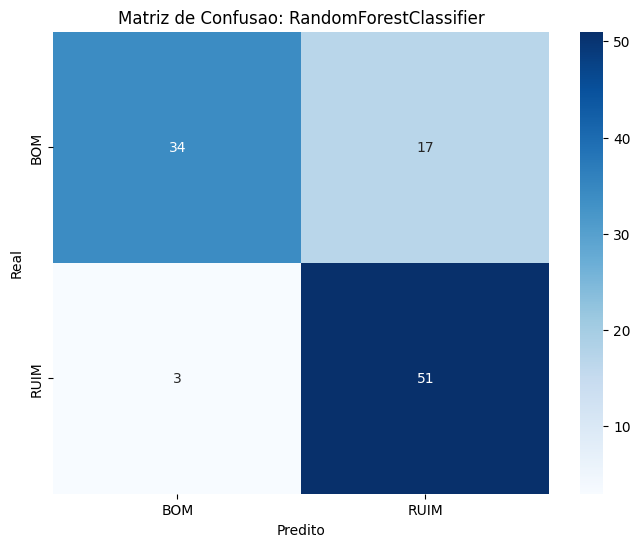

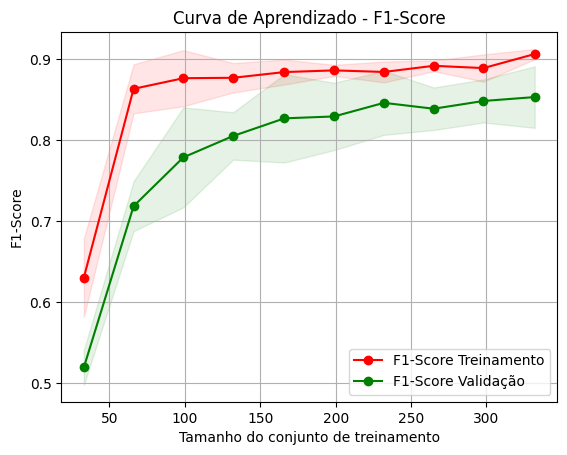

---- SVC ----
              precision    recall  f1-score   support

         BOM       0.89      0.92      0.90        51
        RUIM       0.92      0.89      0.91        54

    accuracy                           0.90       105
   macro avg       0.90      0.91      0.90       105
weighted avg       0.91      0.90      0.90       105

Melhores parametros: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__probability': True, 'svc__random_state': 42}
Melhor F1 ponderado (cross-validation): 0.9254



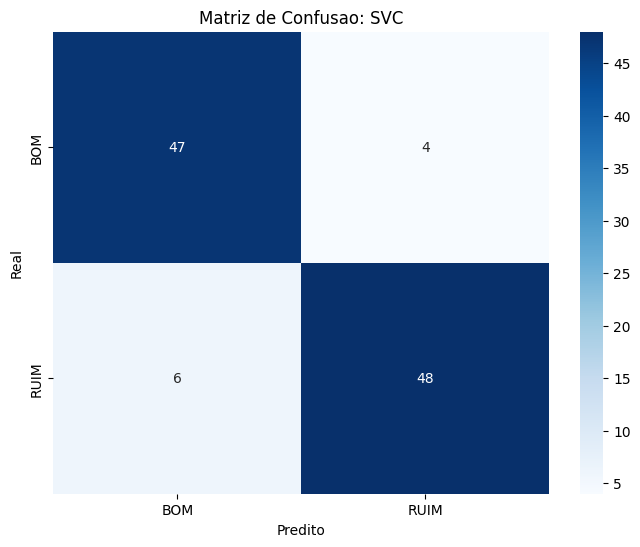

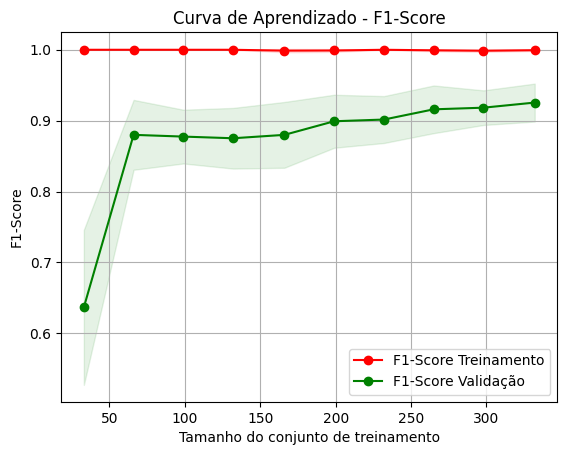

---- NaiveBayes ----
              precision    recall  f1-score   support

         BOM       0.73      0.94      0.82        51
        RUIM       0.92      0.67      0.77        54

    accuracy                           0.80       105
   macro avg       0.83      0.80      0.80       105
weighted avg       0.83      0.80      0.80       105

Melhores parametros: {'naivebayes__alpha': 0.1}
Melhor F1 ponderado (cross-validation): 0.8002



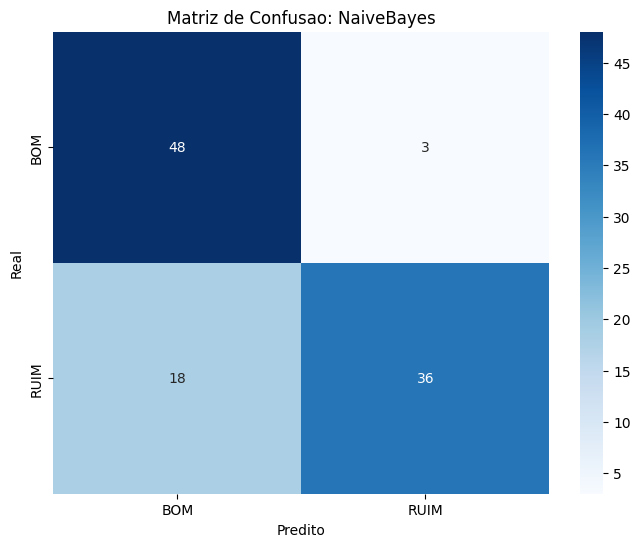

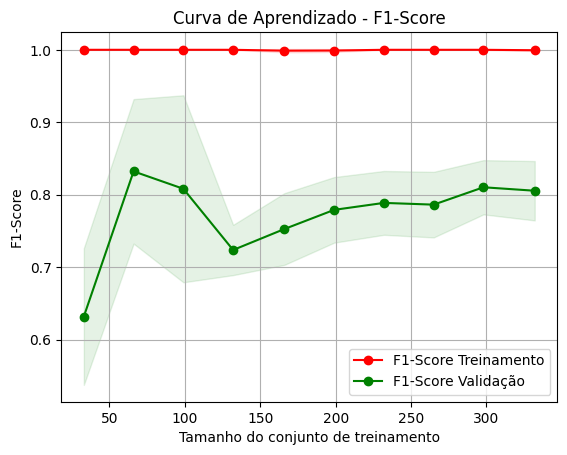

In [41]:
for model_name, (model, params) in models.items():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words = stopwords.words('portuguese'), analyzer='word') ) ,
        (model_name.lower(), model)
    ])
    
    grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='f1_weighted')
    
    grid_search.fit(X_train, y_train)

    results[model_name] = grid_search
    
    # ------------------ CLASSIFICATION REPORT
    y_pred = grid_search.predict(X_test)
    print(f'---- {model_name} ----')
    print(classification_report(y_test, y_pred, target_names=['BOM', 'RUIM']))
    print(f'Melhores parametros: {grid_search.best_params_}')
    print(f'Melhor F1 ponderado (cross-validation): {grid_search.best_score_:.4f}\n')
    
    # ------------------- MATRIZ DE CONFUSÃO
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BOM', 'RUIM'], yticklabels=['BOM', 'RUIM'])
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.title(f'Matriz de Confusao: {model_name}')
    plt.show()
    
    # -------------------- CURVA DE APRENDIZAGEM
    train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, 
                                                            cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Curva de Aprendizado - F1-Score")
    plt.xlabel("Tamanho do conjunto de treinamento")
    plt.ylabel("F1-Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="F1-Score Treinamento")

    # Plotando os resultados de validação
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="F1-Score Validação")

    plt.legend(loc="best")
    plt.show()
    
    

In [42]:
#joblib.dump(results['LogisticRegression'].best_estimator_, './api/utils/best_model.pkl')